In [4]:
#Konwersja zdjec Pokemonow do formatu JPG

#Import potrzebnych bibliotek - PIL do konwersji zdjec, tqdm do paska ładowania
import os
from PIL import Image
from tqdm import tqdm

#Ustawienia dla konwersji
INPUT_FOLDER = "PokemonData"  #folder golwny z Pokemonami
QUALITY = 90                 #jakosc JPG 0-95
DELETE_ORIGINALS = True      #ewentualnie usuanie oryginalow po konwersji

#Konwertowanie obrazu - pojedynczo
def convert_to_jpg(in_path, out_path):
    try:
        #otwarcie obrazu z podanej ścieżki
        #otwarcie w bloku with (automatyczne zamkniecie po zakonczeniu)
        #otwieramy za pomoca funkcji open z PIL.Image do img
        with Image.open(in_path) as img:
            #konwersja do rgb z ewentualnym usunięciem kanału alfa
            rgb_pic = img.convert('RGB')
            #zapis po konwersji do rgb do jpeg z ustaloną jakością
            rgb_pic.save(out_path, 'JPEG', quality=QUALITY)
        return True
    except Exception as exp:
        #obsługa ewentualnego błędu - wyświetlanie ścieżki i zwrócenie False
        print(f"\nBłąd podczas konwersji zdjęcia do .jpg {in_path}: {str(exp)}")
        return False

#Glowna funkcja przetwarzająca
def process_pokemon_folders():
    #rozpoczecie od sprawdzenia istnienia folderu z pokemonami (za pomocą os.path.exist)
    if not os.path.exists(INPUT_FOLDER):
        print(f"Błąd, folder {INPUT_FOLDER} nie istnieje!")
        return
    
    #inicializacja liczników konwersji/pominecia konwersji
    skonwertowane = 0
    pominiete = 0
    
    #Pobranie listy folderow z pokemonami 
    #os.listdir() zwraca listę string z nazwami folderow
    #przez f iterujemy po kazdej nazwie 
    #w if sprawdzane jest czy kazdy element listy to folder os.path.join() tworzy
    #pelna sciezke do foldera f, os.path.isdir() sprawdza czy to folder
    pokemon_folders = [f for f in os.listdir(INPUT_FOLDER) 
                      if os.path.isdir(os.path.join(INPUT_FOLDER, f))]
    
    #komunikat o znalezionej liczbie folderów
    print(f"Znaleziono {len(pokemon_folders)} folderów Pokémonów")
    
    #iterujemy po kazdym folderze z pokemon_folders, tqdm dodaje pasek ladowania
    for pokemon in tqdm(pokemon_folders, desc="Przetwarzanie Pokémonów"):
        #do pokemon_path tworozna jest pełna ścieżka do danego folderu
        pokemon_path = os.path.join(INPUT_FOLDER, pokemon)
        
        #tutaj os.lisdir z racji ze ma podana nazwe folderu pokemona
        #zwraca juz liste plikow ze zdjeciami z folderu
        for filename in os.listdir(pokemon_path):
            #w file_path uzyskujemy sciezke do konkretnego zdjecia
            file_path = os.path.join(pokemon_path, filename)
            
            #Pliki .jpg oraz .jpeg sa pomijane
            if filename.lower().endswith(('.jpg', '.jpeg')):
                pominiete += 1
                continue
                
            #Ewentualne pominięcie plików nie będących obrazami
            if not filename.lower().endswith(('.png', '.bmp', '.gif', '.tiff', '.webp')):
                continue
                
            #W linijce niżej tworzona jest nowa nazwa pliku (os.path.splitext(flnm)[0] zwroci nazwe pliku bez rozszerzenia)
            #na koncu dodajemy .jpg
            nfilename = os.path.splitext(filename)[0] + '.jpg'
            #pobierana jest nowa pelna sciezka do zedytowanego pliku
            npath = os.path.join(pokemon_path, nfilename)
            
            #Dokonanie konwersji przez funkcje wyzej
            if convert_to_jpg(file_path, npath):
                skonwertowane += 1
                if DELETE_ORIGINALS:
                    os.remove(file_path)
            else:
                pominiete += 1
    
    print("\nPodsumowanie:")
    print(f"- Przekonwertowano plików: {skonwertowane}")
    print(f"- Pominięto plików: {pominiete}")

#Uruchom konwersję
process_pokemon_folders()

Znaleziono 150 folderów Pokémonów


Przetwarzanie Pokémonów:   0%|          | 0/150 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Przetwarzanie Pokémonów: 100%|██████████| 150/150 [02:44<00:00,  1.10s/it]


Podsumowanie:
- Przekonwertowano plików: 2552
- Pominięto plików: 11912


In [22]:
import os
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder

#Parametry do zadania
data_dir = "PokemonData"  #folder z datasetem
batch_size = 32 #rozmiar batacha - liczba probek przetwarzana jednoczesnie
valid = 0.1
test = 0.1
random_seed = 42
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

#Transformacja trenignowa - dodano argumentacje w celu wprowadzenia losowosci do danych 
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(512), #domyslny rozmiar dla ResNet - modeli pretrenowanych
    transforms.RandomHorizontalFlip(p=0.5), #50% sznas na odbicie obrazu w poziomie
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1), #argumentacja kolorów dla symulacji roznych
    #warunkow oswietlenia
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std), #normalizacja zgodnie z ImageNet - dla modeli pretrenowanych
])

#Transformacje dla walidacji/testów (bez augmentacji)
val_test_transform = transforms.Compose([
    transforms.Resize(512), #przeskalowanie do 256x256
    transforms.CenterCrop(512), #wyciecie srodka dla zgodnosci z ResNet
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std), #normalziacja jak wyzej
])

#Zaladowanie datasetu z zastosowaniem transformacji treningowych z argumentacją
dataset = ImageFolder(root=data_dir, transform=train_transform)

#Podzial zbioru
dataset_size = len(dataset) #Calkowita liczba obrazow
valid_size = int(valid * dataset_size) #Rozmiar zbioru walidacyjnego
test_size = int(test * dataset_size) #Rozmiar zbioru testowego
train_size = dataset_size - valid_size - test_size #Rozmiar zbioru treningowego

#Podział datasetu na 3 części z użyciem random_split - zapewnienie losowego i powtarzalnego pozniej podzialu
train_dataset, valid_dataset, test_dataset = random_split(
    dataset,
    [train_size, valid_size, test_size],
    generator=torch.Generator().manual_seed(random_seed)
)

#Nadpisz transformacje dla walidacji i testów (usuń augmentację)
valid_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

#Stworzenie dataloaderow, shuffle mowi czy sie miesza czy nie
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Sprawdź rozmiary
print(f"Treningowych: {len(train_dataset)}, Walidacyjnych: {len(valid_dataset)}, Testowych: {len(test_dataset)}")
print(f"Liczba klas: {len(dataset.classes)}")
print(f"Nazwy klas: {dataset.classes}")
print(f"Przykładowy kształt batcha: {next(iter(train_loader))[0].shape}")

Treningowych: 11360, Walidacyjnych: 1419, Testowych: 1419
Liczba klas: 150
Nazwy klas: ['Abra', 'Aerodactyl', 'Alakazam', 'Alolan Sandslash', 'Arbok', 'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise', 'Bulbasaur', 'Butterfree', 'Caterpie', 'Chansey', 'Charizard', 'Charmander', 'Charmeleon', 'Clefable', 'Clefairy', 'Cloyster', 'Cubone', 'Dewgong', 'Diglett', 'Ditto', 'Dodrio', 'Doduo', 'Dragonair', 'Dragonite', 'Dratini', 'Drowzee', 'Dugtrio', 'Eevee', 'Ekans', 'Electabuzz', 'Electrode', 'Exeggcute', 'Exeggutor', 'Farfetchd', 'Fearow', 'Flareon', 'Gastly', 'Gengar', 'Geodude', 'Gloom', 'Golbat', 'Goldeen', 'Golduck', 'Golem', 'Graveler', 'Grimer', 'Growlithe', 'Gyarados', 'Haunter', 'Hitmonchan', 'Hitmonlee', 'Horsea', 'Hypno', 'Ivysaur', 'Jigglypuff', 'Jolteon', 'Jynx', 'Kabuto', 'Kabutops', 'Kadabra', 'Kakuna', 'Kangaskhan', 'Kingler', 'Koffing', 'Krabby', 'Lapras', 'Lickitung', 'Machamp', 'Machoke', 'Machop', 'Magikarp', 'Magmar', 'Magnemite', 'Magneton', 'Mankey', 'Maro

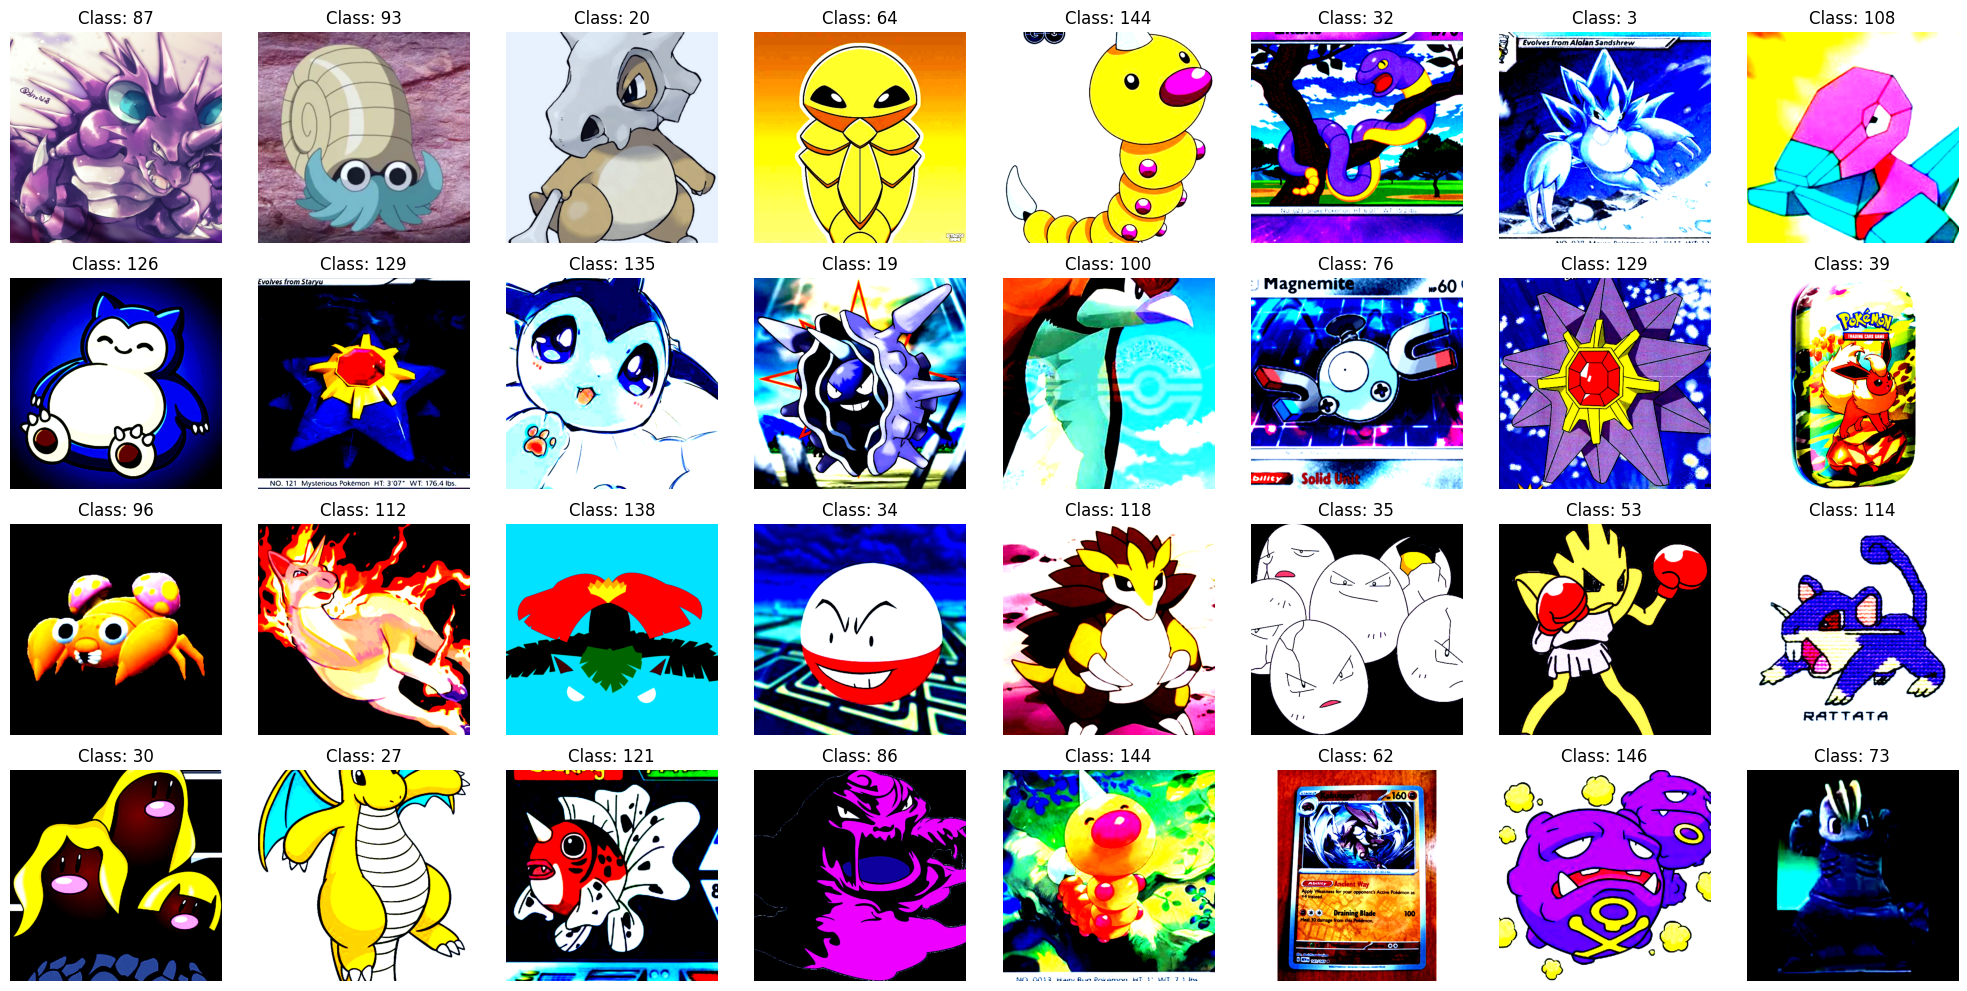

In [23]:
import matplotlib.pyplot as plt
import torch

#Odworcenie normalizacji (chcac wysiwetlic obrazy)
def denormalize(tensor, mean=imagenet_mean, std=imagenet_std):
    tensor = tensor.clone() #kopia tensora
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m) #wzor odwrotny (tensor*odchylenie)+srednia
    return torch.clamp(tensor, 0, 1)

#Pobierz partii batch obrazów
images, labels = next(iter(train_loader))
#Odwrócenie normalizacji
images = denormalize(images)

#Siatka dla obrazów 4x8 + rozmiar wykresu w figure
fig, axes = plt.subplots(4, 8, figsize=(20, 10))
axes = axes.flatten()

# Wyświetl obrazy
for i in range(min(len(images), 32)):
    img = images[i].permute(1, 2, 0)  #kanal wysokosc szerokosc na wysokosc szerokosc kanal
    axes[i].imshow(img.numpy())
    axes[i].axis('off')
    axes[i].set_title(f"Class: {labels[i].item()}")

plt.tight_layout()
plt.show()

In [ ]:










'''


# 2. Transformacje danych
data_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# 3. Ładowanie pełnego datasetu
full_dataset = ImageFolder(root=data_dir, transform=data_transforms)

# 4. Podział na zbiór treningowy i testowy
train_size = int((1 - validation_split) * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(
    full_dataset, 
    [train_size, test_size],
    generator=torch.Generator().manual_seed(random_seed)
)

# 5. Tworzenie DataLoaderów
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 6. Sprawdzenie podstawowych informacji
print(f"Liczba klas: {len(full_dataset.classes)}")
print(f"Nazwy klas: {full_dataset.classes}")
print(f"Liczba obrazów treningowych: {len(train_dataset)}")
print(f"Liczba obrazów testowych: {len(test_dataset)}")
print(f"Przykładowy kształt batcha: {next(iter(train_loader))[0].shape}")

# 7. Funkcja do wyświetlania obrazków
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # odwrócenie normalizacji
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

# 8. Wyświetlenie przykładowego batcha
dataiter = iter(train_loader)
images, labels = next(dataiter)

fig = plt.figure(figsize=(12, 8))
for i in range(min(6, batch_size)):  # pokaż 6 obrazków
    ax = fig.add_subplot(2, 3, i+1)
    imshow(images[i])
    ax.set_title(full_dataset.classes[labels[i]])
plt.tight_layout()
plt.show()
'''